## SBI Interactive Tutorial
---

In this interactive tutorial we demonstrate basic usage of `sddr` along with `SBI`




In [8]:
import numpy as np
import emcee
from getdist import plots, MCSamples
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from scipy.linalg import eigh
# import harmonic as hm
from nautilus import Prior, Sampler
from sbi.inference import NLE
from sbi.inference.posteriors.posterior_parameters import VIPosteriorParameters
import torch

## Notebook outline

We're going to calculate a SDDR with a simple Gaussian model

First, let's define some helper functions


In [36]:
def ln_likelihood(x, simulator, data, inv_cov):
    x = np.atleast_2d(x)
    r = data - simulator(x)
    chi2 = np.einsum("ij,ij->i", r, np.dot(inv_cov, r.T).T)
    return -0.5 * chi2


def ln_posterior(x, simulator, data, inv_cov, prior):
    """Compute the log posterior."""
    x = np.atleast_2d(x)
    ln_posterior = ln_likelihood(x, simulator, data, inv_cov) + prior.logpdf(x)
    return ln_posterior


def init_diag_cov(ndim):
    """Initialise random diagonal covariance matrix.

    Args:

        ndim: Dimension of Gaussian.

    Returns:

        double ndarray[ndim, ndim]: Covariance matrix of shape (ndim,ndim).

    """

    cov = np.zeros((ndim, ndim))
    diag_cov = np.ones(ndim)
    np.fill_diagonal(cov, diag_cov)

    return cov


def init_cov(ndim):
    """Initialise random non-diagonal covariance matrix.

    Args:

        ndim: Dimension of Gaussian.

    Returns:

        cov: Covariance matrix of shape (ndim,ndim).

    """

    cov = np.zeros((ndim, ndim))
    diag_cov = np.ones(ndim) + np.random.randn(ndim) * 0.1
    np.fill_diagonal(cov, diag_cov)
    off_diag_size = 0.5
    for i in range(ndim - 1):
        cov[i, i + 1] = (
            (-1) ** i * off_diag_size * np.sqrt(cov[i, i] * cov[i + 1, i + 1])
        )
        cov[i + 1, i] = cov[i, i + 1]

    return cov

### MCMC functions

In [37]:
def run_mcmc(
    nchains, nparams, ln_posterior, mock_simulator, data, inv_cov, prior, samples_per_chain, nburn, 
):
    pos = prior.rvs(nchains)

    sampler = emcee.EnsembleSampler(
        nwalkers=nchains,
        ndim=nparams,
        log_prob_fn=ln_posterior,
        vectorize=True,
        # moves=emcee.moves.StretchMove(),
        args=[mock_simulator, data, inv_cov, prior],
    )

    sampler.run_mcmc(pos, samples_per_chain, progress=True)

    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])
    flat_samples, flat_weights = np.unique(
        sampler.get_chain(flat=True), axis=0, return_counts=True
    )
    flat_log_prob, _ = np.unique(
        sampler.get_log_prob(flat=True), axis=0, return_counts=True
    )

    samples = np.ascontiguousarray(sampler.chain[:, nburn:, :])
    log_prob = np.ascontiguousarray(sampler.lnprobability[:, nburn:])

    return flat_samples, flat_weights, flat_log_prob, samples, log_prob

### Plotting function

In [38]:
def triangle_plot(
    mc_samples,
    truth=None,
    params_to_plot=None,
    savefig=False,
    filename=None,
):
    # Triangle plot
    plt.close()
    with mpl.rc_context():
        # g = plots.getSubplotPlotter(width_inch=12)
        g = plots.getSubplotPlotter()
        g.settings.figure_legend_frame = False
        g.settings.alpha_filled_add = 0.6
        g.settings.axes_fontsize = 18
        g.settings.legend_fontsize = 18
        g.settings.lab_fontsize = 18
        if params_to_plot:
            g.triangle_plot(
                mc_samples, params=params_to_plot, filled_compare=True, normalized=True
            )
        else:
            g.triangle_plot(mc_samples, filled_compare=True, normalized=True)

        if truth is not None:
            g.add_param_markers(truth, color="black", ls="--")

        plt.subplots_adjust(hspace=0, wspace=0)

        if savefig:
            plt.savefig(filename, bbox_inches="tight")
        plt.show()

## Fix the seed


In [39]:
np.random.seed(42)

## Set priors

Can be uniform or gaussian, here we use an uncorrelated Gaussian prior


In [40]:
n_params = 5
n_nested = 2

means = np.zeros(n_params)
prior_cov = np.diag(np.ones(n_params)*2.0 ** 2)
inv_prior_cov = np.linalg.inv(prior_cov)
prior = multivariate_normal(mean=means, cov=prior_cov)
nested_prior = multivariate_normal(
    mean=means[:-n_nested], cov=prior_cov[:-n_nested, :-n_nested]
)
marginal_prior = multivariate_normal(
    mean=means[-n_nested:], cov=prior_cov[-n_nested:, -n_nested:]
)

## Create the Gaussian likelihood first 

In the case that we are considering, we will have a data vector that is 3 numbers long, and a super model with 5 parameters, and a nested model with 3 parameters.

Shared parameters are denoted as $\theta$, and the parameters that extend the nested model to the super parameter are denoted with $\eta$. These are also the nested parameters. 

The corresponding Gaussian likelihood is given by
\begin{equation}
	\mathcal{L}( \bm{d} \mid \bm{\theta}) = \frac{\exp\bigl( -\frac{1}{2} (\bm{d} - \bm{\mu}(\bm{\theta, \eta}))^\text{T} \Sigma^{-1} (\bm{d} - \bm{\mu}(\bm{\theta, \eta}) \bigr)}{(2 \pi)^{3/2}|\Sigma|^{1/2}}. 
\end{equation}

For our super model, we have
\begin{align}
	\bm{\mu}(\bm{\theta, \eta}) & = \begin{bmatrix}
                                            \theta_1 + \mathrm{arcsinh}(\theta_4)\\
                                            \arctan(\theta_2) + \eta_1 \\
                                            e^{0.5 \times \theta_3} + \eta_2
	                                        \end{bmatrix}.
\end{align}

Whilst for the nested model, we fix $\eta_1 = -2$ and $\eta_2 = 0.2$.

In [41]:
ndata = 40
cov = init_cov(ndata)
inv_cov = np.linalg.inv(cov)
 
theta_truth = np.array([0.1, -0.5, 0.5])
eta_truth = np.array([0.2, 0.3])

truth = np.concatenate((theta_truth, eta_truth))

def mock_simulator(theta):
    theta = np.atleast_2d(theta)
    model_prediction = np.zeros((theta.shape[0], ndata))
    x_grid = np.arange(ndata)
    model_prediction = (theta[:, 0][:, np.newaxis] * x_grid**0.2 + 
                        theta[:, 1][:, np.newaxis] * x_grid**0.4 + 
                        theta[:, 2][:, np.newaxis] * x_grid**0.6 + 
                        theta[:, 3][:, np.newaxis] * x_grid**0.8 + 
                        theta[:, 4][:, np.newaxis])
    return model_prediction

def nested_mock_simulator(theta):   
    theta = np.atleast_2d(theta)
    model_prediction = np.zeros((theta.shape[0], ndata))
    x_grid = np.arange(ndata)
    model_prediction = (theta[:, 0][:, np.newaxis] * x_grid**0.2 + 
                        theta[:, 1][:, np.newaxis] * x_grid**0.4 + 
                        theta[:, 2][:, np.newaxis] * x_grid**0.6 + 
                        eta_truth[0] * x_grid**0.8 + 
                        eta_truth[1]) 
    return model_prediction

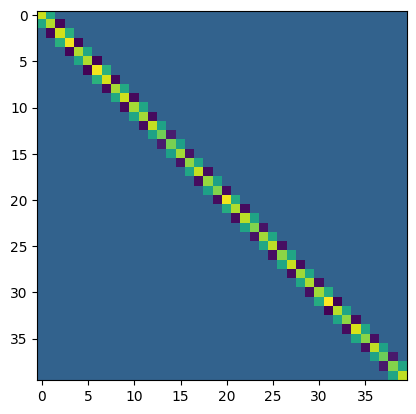

In [42]:
plt.imshow(cov)
plt.show()

## Generate some fake data with Gaussian noise


In [43]:
noiseless_data = mock_simulator(truth)[0]
data = np.random.multivariate_normal(noiseless_data, cov)

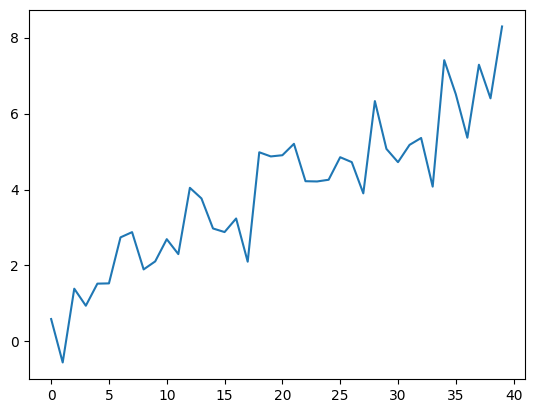

In [44]:
plt.plot(data, label="Data")
plt.show()

## Let's use the same simulator to generate some simulated data with Gaussian nose

In [45]:
sim_samples = np.random.multivariate_normal(means, prior_cov, size=10000)
simulated_data = mock_simulator(sim_samples)

In [46]:
noisey_simulated_data = np.zeros((simulated_data.shape[0], simulated_data.shape[1]))
for i in range(simulated_data.shape[0]):
    noisey_simulated_data[i] = np.random.multivariate_normal(simulated_data[i], cov)

## Let's setup a compression method with CCA

In [47]:
cca_cov = np.cov(sim_samples.T, noisey_simulated_data.T)
cp = cca_cov[:n_params,:n_params]
cd = cca_cov[n_params:,n_params:]
cpd = cca_cov[:n_params,n_params:]

# This 'cl' can be understood as the projection of 'cp' to data vector space
cl = cpd.T@np.linalg.inv(cp)@cpd

# As seen in the paper, this generalized eigenvalue problem is equivalent to CCA
# but is more numerical stable as 'cd' and 'cd-cl' are both invertible.
# This problem is motivated as mutual information maximization under Gaussian linear model assumptions
evals, evecs = eigh(cd, cd - cl)

# In the context of the CCA, only min( dim(param), dim(data vector) ) components are real and the rest are noise. 
evals = evals[::-1][:n_params]
evecs = evecs[:,::-1][:,:n_params]

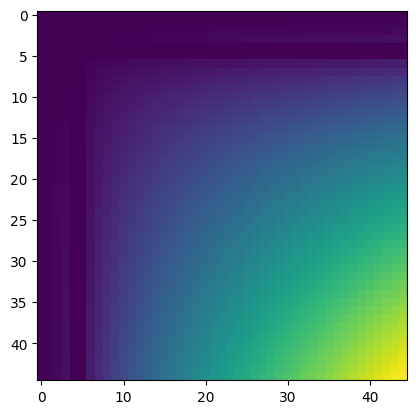

In [48]:
plt.imshow(cca_cov)

In [53]:
compressed_test = data@evecs
uncompressed_test = compressed_test@evecs.T

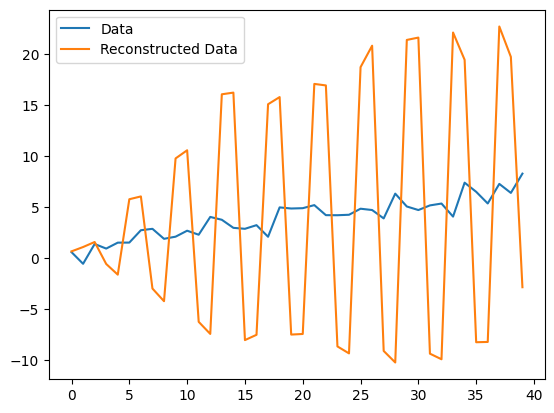

In [56]:
plt.plot(data, label="Data")
plt.plot(uncompressed_test, label="Reconstructed Data")
plt.legend()
plt.show()

## Now let's do some SBI with NLE

In [33]:
# Convert to torch tensors
means_torch = torch.tensor(means, dtype=torch.float32)
prior_cov_torch = torch.tensor(prior_cov, dtype=torch.float32)

# Create torch distribution
prior_torch = torch.distributions.MultivariateNormal(means_torch, prior_cov_torch)

In [15]:
num_sims = 2000
num_rounds = 3
inference = NLE(prior_torch)
proposal = prior_torch
for _ in range(num_rounds):
    theta = proposal.sample((num_sims,))
    noiseless_x = mock_simulator(theta.detach().numpy())
    x = np.zeros((noiseless_x.shape[0], noiseless_x.shape[1]))
    for i in range(noiseless_x.shape[0]):
        x[i] = np.random.multivariate_normal(noiseless_x[i], cov)
    compressed_x = x@evecs
    compressed_x = torch.tensor(x, dtype=torch.float32)
    _ = inference.append_simulations(theta, compressed_x).train()
    posterior = inference.build_posterior().set_default_x(torch.tensor(data, dtype=torch.float32))
    proposal = posterior

 Neural network successfully converged after 378 epochs.

/Users/kiyam/Code/astrodat-2025/.venv/lib/python3.12/site-packages/sbi/inference/posteriors/mcmc_posterior.py:126: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/7000 [00:00<?, ?it/s]

 Neural network successfully converged after 111 epochs.

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/7000 [00:00<?, ?it/s]

 Neural network successfully converged after 113 epochs.

In [16]:
nle_posterior_theta = posterior.sample((20000,), x=data, num_chains=100)

Generating 100 MCMC inits via resample strategy:   0%|          | 0/100 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/45000 [00:00<?, ?it/s]

In [17]:
nle_posterior_samples = nle_posterior_theta.detach().numpy()
nle_posterior_log_probs = posterior.potential(nle_posterior_theta.detach(), x=torch.tensor(data, dtype=torch.float32)).numpy()

## Get some posterior samples with emcee


In [18]:
nchains = 100
samples_per_chain = 6000
nburn = 1000

## Run MCMC for the larger model


In [19]:
(
    super_samples,
    super_weights,
    super_log_prob,
    harmonic_super_samples,
    harmonic_super_log_prob,
) = run_mcmc(
    nchains,
    n_params,
    ln_posterior,
    mock_simulator,
    data,
    inv_cov,
    prior,
    samples_per_chain, 
    nburn)

100%|██████████| 6000/6000 [00:01<00:00, 3069.23it/s]


## Run MCMC for the nested model

Note that the outputs here contain samples in a flat format, and also split by chain to make it easier to ingest for harmonic later on in the script

In [20]:
(
    nested_samples,
    nested_weights,
    nested_log_prob,
    harmonic_nested_samples,
    harmonic_nested_log_prob,
) = run_mcmc(
    nchains,
    n_params - n_nested,
    ln_posterior,
    nested_mock_simulator,
    data,
    inv_cov,
    nested_prior,
    samples_per_chain, 
    nburn)

100%|██████████| 6000/6000 [00:01<00:00, 3236.10it/s]


## Plot!


In [21]:
param_names = [f"theta_{i+1}" for i in range(n_params)]
param_labels = [rf"\theta_{i+1}" for i in range(n_params)]
truth_marker = dict(zip(param_names, [truth[i] for i in range(n_params)]))

### Make the getdist MC objects

In [22]:
super_mc_samples = MCSamples(
    samples=super_samples,
    weights=super_weights,
    names=param_names,
    labels=param_labels,
    label="Super model",
    sampler="mcmc",
)
nested_mc_samples = MCSamples(
    samples=nested_samples,
    weights=nested_weights,
    names=param_names[:-n_nested],
    labels=param_labels[:-n_nested],
    label="Nested model",
    sampler="mcmc",
)

super_nle_samples = MCSamples(
    samples=nle_posterior_samples,
    names=param_names,
    labels=param_labels,
    label="Super SBI model",
    sampler="mcmc",
)

Removed no burn in
Removed no burn in
Removed no burn in


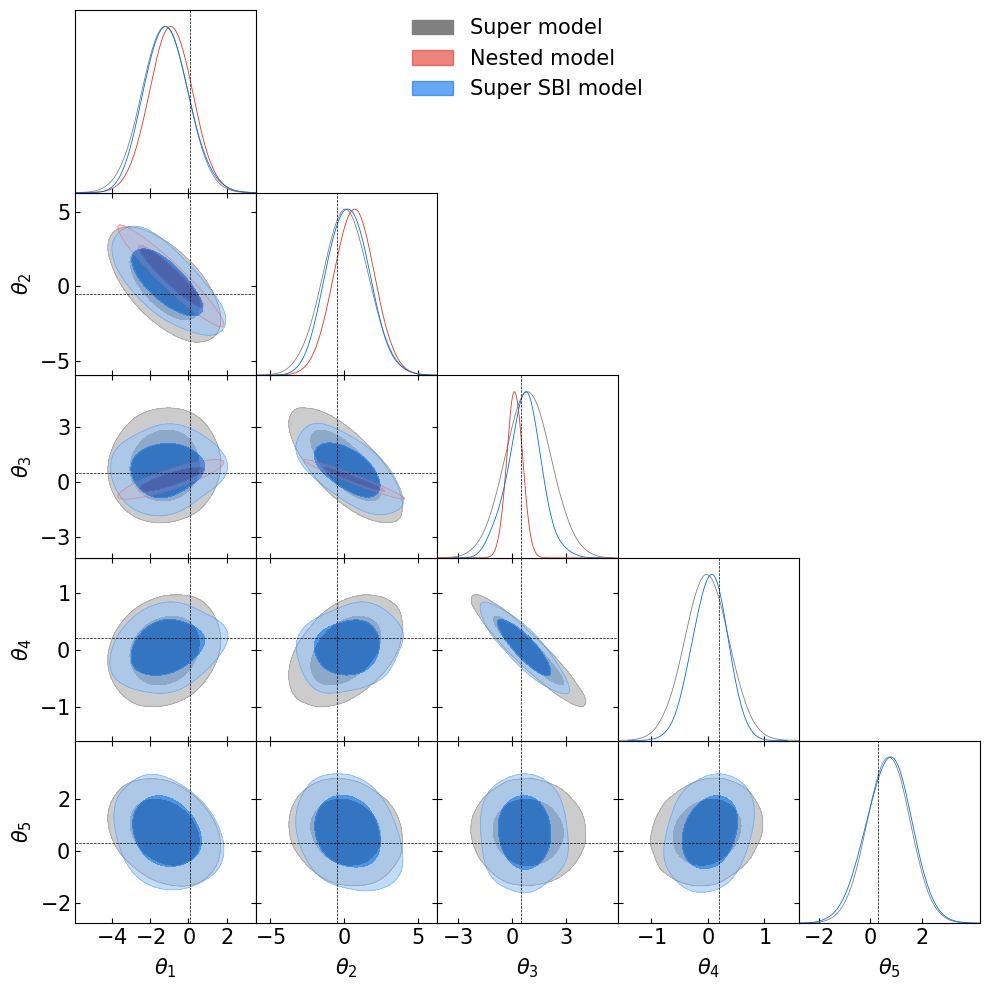

In [23]:
triangle_plot(
    [super_mc_samples, nested_mc_samples, super_nle_samples],
    truth=truth_marker)

## Now calculate the Savage Dickey Density Ratio for $\eta_1$ and $\eta_2$


In [24]:
marginalised_samples = nle_posterior_samples[:, -n_nested:]
log_prior_prob = np.log(marginal_prior.pdf(eta_truth))

## We can calculate the SDDR with a histogram

In [25]:
histogram_model = hm.model_classical.HistogramModel(ndim=2, nbins=80)
histogram_sddr = hm.sddr.sddr(model=histogram_model, samples=marginalised_samples)
hist_log_bf, hist_log_bf_std = histogram_sddr.log_bayes_factor(log_prior=log_prior_prob,
                                                    value=eta_truth,
                                                    nbootstraps=100,
                                                    bootstrap_proportion=0.5,
                                                    bootstrap=True)

print(
    f"The Bayes factor calculated from the SDDR with the classical histogram model is: {hist_log_bf:.4f} \u00b1 {hist_log_bf_std:.4f}"
)

Bootstrapping: 100%|██████████| 100/100 [00:00<00:00, 607.40it/s]

The Bayes factor calculated from the SDDR with the classical histogram model is: 2.4182 ± 0.4094


## We can calculate the SDDR by learning the marginal posterior with a flow

In [26]:
flow_model = hm.model.RQSplineModel(ndim_in=2, standardize=True, temperature=1.0)
flow_sddr = hm.sddr.sddr(model=flow_model, samples=marginalised_samples)
flow_log_bf, flow_log_bf_std = flow_sddr.log_bayes_factor(log_prior=log_prior_prob,
                                          value=eta_truth,
                                          nbootstraps=10,
                                          bootstrap_proportion=0.5,
                                          bootstrap=True,
                                          epochs=10)
print(
    f"The Bayes factor calculated from the SDDR with the normalising flow model is: {flow_log_bf:.4f} \u00b1 {flow_log_bf_std:.4f}"
)

Bootstrapping: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]

The Bayes factor calculated from the SDDR with the normalising flow model is: 2.4466 ± 0.0585


## Repeat the evidence calculation but now using harmonic

### Configure some machine learning parameters


In [27]:
training_proportion = 0.5
temperature = 0.9
standardize = True
flow_type = "RQSpline"
epochs_num = 10

### Function to run harmonic


In [28]:
def run_harmonic(
    samples,
    log_prob,
    nparams,
    training_proportion,
    epochs_num,
    temperature,
    standardize,
):
    # ===================================================================
    # Configure emcee chains for harmonic
    # ===================================================================
    hm.logs.info_log("Configure chains...")
    """
    Configure chains for the cross-validation stage.
    """
    chains = hm.Chains(nparams)
    chains.add_chains_3d(samples, log_prob)
    chains_train, chains_test = hm.utils.split_data(
        chains, training_proportion=training_proportion
    )

    # =======================================================================
    # Fit model
    # =======================================================================
    hm.logs.info_log("Fit model for {} epochs...".format(epochs_num))
    model = hm.model.RQSplineModel(
        nparams, standardize=standardize, temperature=temperature
    )
    model.fit(chains_train.samples, epochs=epochs_num)

    # ===================================================================
    # Computing evidence using learnt model and emcee chains
    # ===================================================================
    hm.logs.info_log("Compute evidence...")
    """
    Instantiates the evidence class with a given model. Adds some chains 
    and computes the log-space evidence (marginal likelihood).
    """
    ev = hm.Evidence(chains_test.nchains, model)
    ev.add_chains(chains_test)
    ln_evidence, _ = ev.compute_ln_evidence()
    ln_evidence_err_neg, ln_evidence_err_pos = ev.compute_ln_inv_evidence_errors()

    return ln_evidence, ln_evidence_err_neg, ln_evidence_err_pos

In [29]:
chains = hm.Chains(n_params)
chains.add_chains_3d(harmonic_super_samples, harmonic_super_log_prob)

In [30]:
harmonic_ln_evidence, harmonic_ln_ev_err_neg, harmonic_ln_ev_err_pos = run_harmonic(
    samples=harmonic_super_samples,
    log_prob=harmonic_super_log_prob,
    nparams=n_params,
    training_proportion=training_proportion,
    epochs_num=epochs_num,
    temperature=temperature,
    standardize=standardize
    )

In [31]:
(
    harmonic_nested_ln_evidence,
    harmonic_nested_ln_ev_err_neg,
    harmonic_nested_ln_ev_err_pos,
) = run_harmonic(
    samples=harmonic_nested_samples,
    log_prob=harmonic_nested_log_prob,
    nparams=n_params - n_nested,
    training_proportion=training_proportion,
    epochs_num=epochs_num,
    temperature=temperature,
    standardize=standardize
    )

In [32]:
print(
    f"The log evidence from Harmonic is: {harmonic_ln_evidence:.4f} (+{harmonic_ln_ev_err_pos:.4f},{harmonic_ln_ev_err_neg:.4f})"
)
print(
    f"The log evidence for the nested model from Harmonic is: {harmonic_nested_ln_evidence:.4f} (+{harmonic_nested_ln_ev_err_pos:.4f},{harmonic_nested_ln_ev_err_neg:.4f})"
)
print(
    f"The log evidence ratio from Harmonic is: {harmonic_nested_ln_evidence - harmonic_ln_evidence:.4f} (+{np.sqrt(harmonic_nested_ln_ev_err_pos**2+harmonic_ln_ev_err_pos**2):.4f},-{np.sqrt(harmonic_nested_ln_ev_err_neg**2+harmonic_ln_ev_err_neg**2):.4f})"
)

The log evidence from Harmonic is: -26.4878 (+0.0047,-0.0047)
The log evidence for the nested model from Harmonic is: -24.2865 (+0.0061,-0.0062)
The log evidence ratio from Harmonic is: 2.2013 (+0.0077,-0.0078)
